In [1]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import dlib

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)
os.getcwd()

'/Users/pareshar/Personal/Github/Facial-feature-detector'

In [3]:
# static variables
path_to_images = "data/images_me/"
image_files = os.listdir(path_to_images)

In [4]:
def histogram_performance(left_half, right_half):
    hist_left = cv2.calcHist([left_half], [0], None, [256], [0, 256])
    hist_right = cv2.calcHist([right_half], [0], None, [256], [0, 256])

    # Normalize histograms
    hist_left /= hist_left.sum()
    hist_right /= hist_right.sum()

    # Compare using various methods
    correlation = cv2.compareHist(hist_left, hist_right, cv2.HISTCMP_CORREL)
    chi_square = cv2.compareHist(hist_left, hist_right, cv2.HISTCMP_CHISQR)
    intersection = cv2.compareHist(hist_left, hist_right, cv2.HISTCMP_INTERSECT)
    bhattacharyya = cv2.compareHist(hist_left, hist_right, cv2.HISTCMP_BHATTACHARYYA)

    return correlation, chi_square, intersection, bhattacharyya

def orb_detector(left_half, right_half):
    """The fewer the matches (or the greater the average distance), the more dissimilar the images"""

    orb = cv2.ORB_create()
    keypoints_left, descriptors_left = orb.detectAndCompute(left_half, None)
    keypoints_right, descriptors_right = orb.detectAndCompute(right_half, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors_left, descriptors_right)
    matches = sorted(matches, key=lambda x: x.distance)
    return len(matches)

def align_face(face_image, predictor_path="models/face_alignment/shape_predictor_68_face_landmarks.dat"):
    # If the image is not grayscale, convert it.
    if len(face_image.shape) == 3 and face_image.shape[2] == 3:
        gray = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
    else:
        gray = face_image.copy()

    # Initialize dlib's face detector and shape predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    
    # Detect the face in the image
    faces = detector(gray, 1)
    if len(faces) == 0:
        print("No face detected.")
        return face_image

    face = faces[0]
    
    # Get the landmarks/parts for the face
    shape = predictor(gray, face)
    
    # Get the center between the two eyes for the face
    left_eye_center = (0.5 * (shape.part(36).x + shape.part(39).x), 0.5 * (shape.part(36).y + shape.part(39).y))
    right_eye_center = (0.5 * (shape.part(42).x + shape.part(45).x), 0.5 * (shape.part(42).y + shape.part(45).y))
    
    # Compute the angle between the two eyes
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(dy, dx))
    
    # Compute the desired right eye x-coordinate based on the left eye x-coordinate
    desired_right_eye_x = 1.0 - 0.3
    
    # Determine the scale of the new resulting image
    dist = np.sqrt((dx ** 2) + (dy ** 2))
    desired_dist = (desired_right_eye_x - 0.3)
    desired_dist *= 224  # the width of image we want to use
    scale = desired_dist / dist
    
    # Compute center (x, y) between the two eyes in the input image
    eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2, (left_eye_center[1] + right_eye_center[1]) // 2)
    
    # Grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)
    
    # Update the translation component of the matrix at the last column
    tX = 224 * 0.5
    tY = 224 * 0.4
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])
    
    # Use the affine transformation to produce the aligned face
    aligned = cv2.warpAffine(gray, M, (224, 224), flags=cv2.INTER_CUBIC)
    
    return aligned

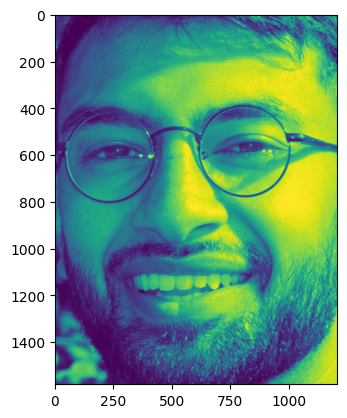

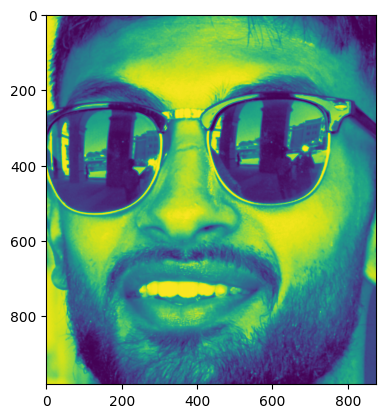

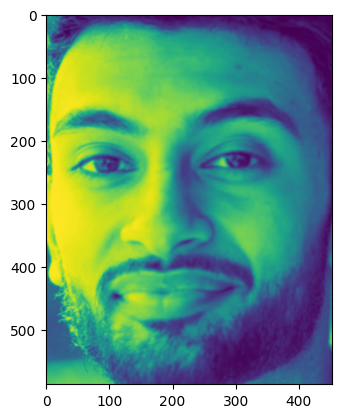

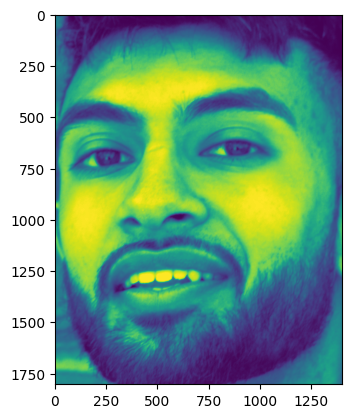

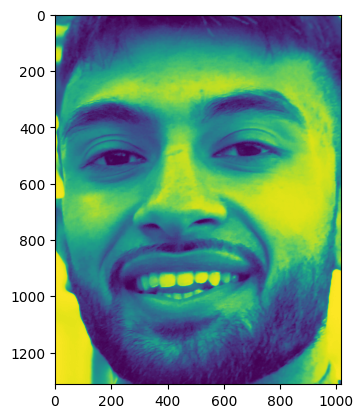

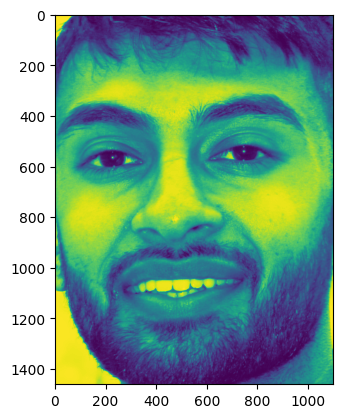

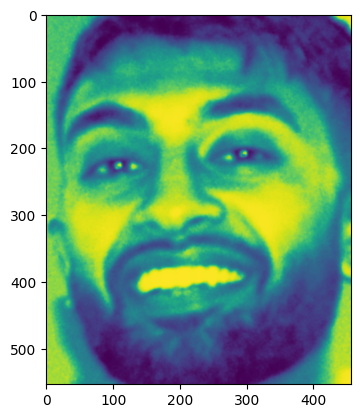

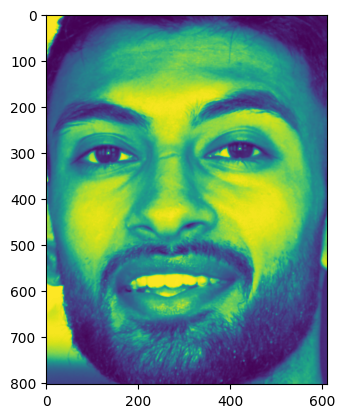

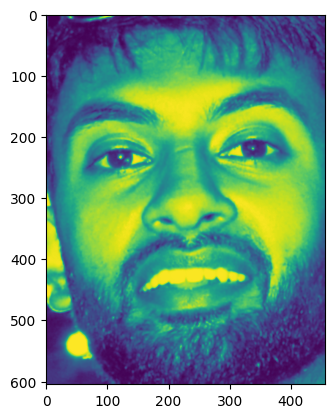

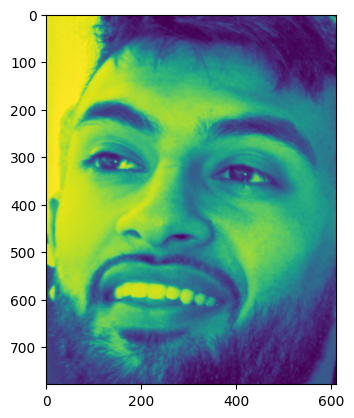

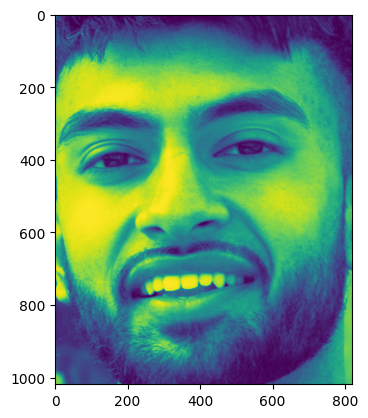

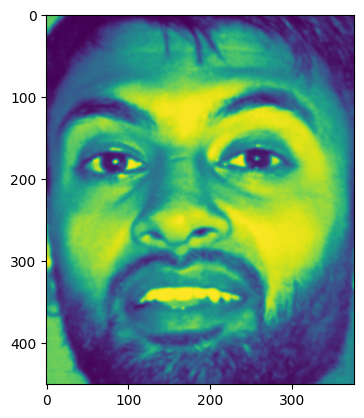

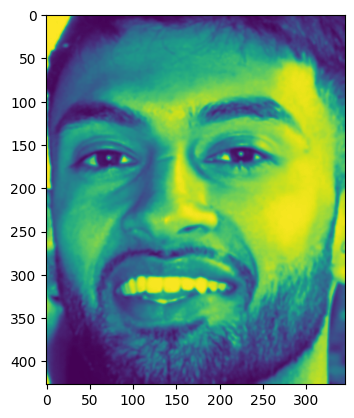

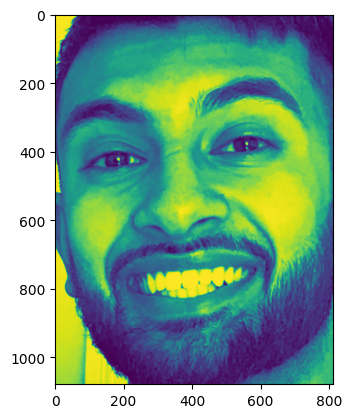

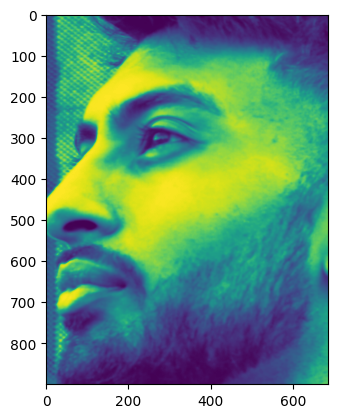

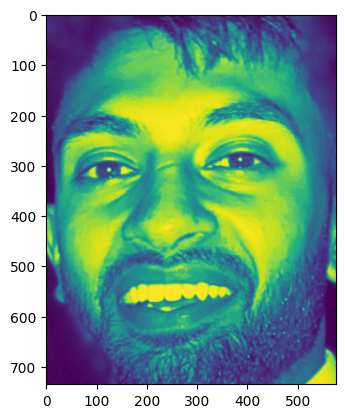

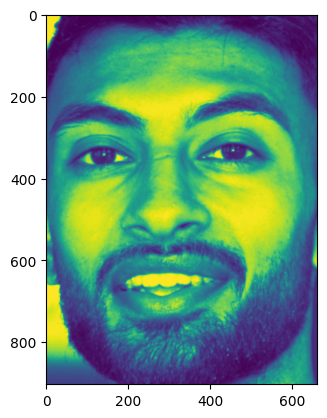

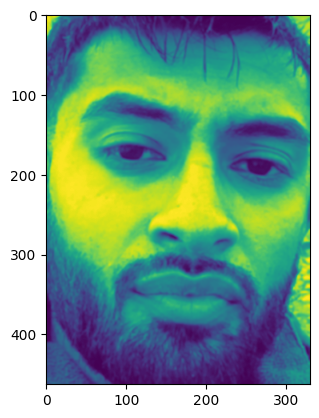

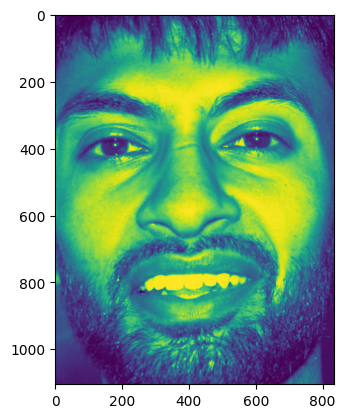

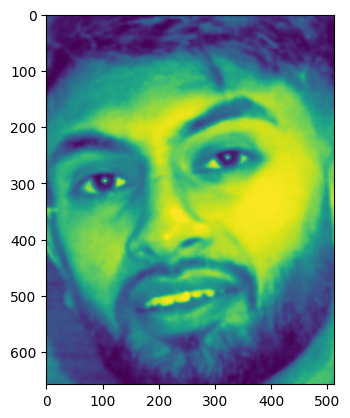

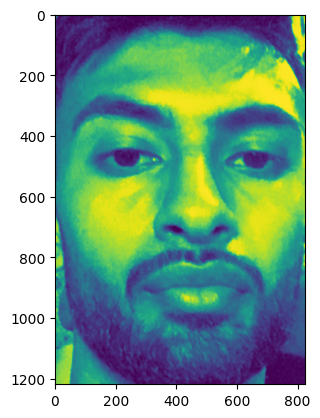

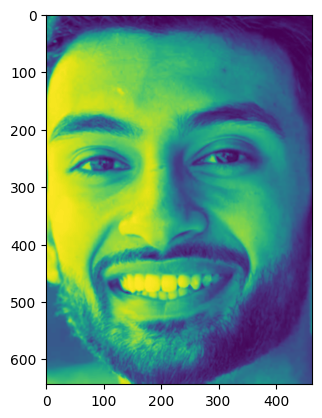

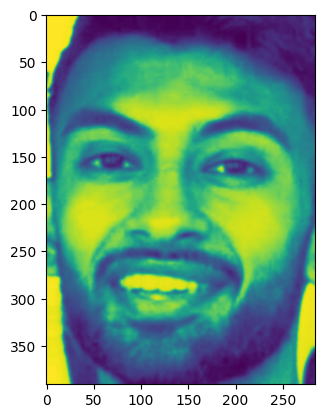

In [5]:
df = pd.DataFrame(columns=["file_name", "model", "structural_similarity", "cosine_distance", "mse", "mae",
                           "histogram_correlation", "histogram_intersection",
                           "orb_detector_matches", "pixel_difference"])
df_list = []

for image_file in image_files:
    image = cv2.imread(path_to_images + image_file)
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image=image, scalefactor=1.0, size=(300, 300))
    
    net = cv2.dnn.readNetFromCaffe("models/face_detection/deploy.prototxt.txt", "models/face_detection/res10_300x300_ssd_iter_140000.caffemodel")
    net.setInput(blob)
    detections = net.forward()  
    
    best_face_data = None
    lowest_mse = float('inf')
    
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.97:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            face = image[startY:endY, startX:endX]
            
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            face = cv2.equalizeHist(face) # remove illumination
            face = cv2.GaussianBlur(face, (5, 5), 0) # remove noise
            # face = align_face(face) # optional - make things slower and small effect
            
            mid = face.shape[1] // 2
            left_half = face[:, :mid]
            right_half = face[:, mid:]
            
            right_half = cv2.resize(right_half, (left_half.shape[1], left_half.shape[0]))
            right_half = cv2.flip(right_half, 1)    
            
            plt.imshow(face)
            plt.show()    

            structural_similarity, _ = ssim(left_half, right_half, full=True)
            cosine_distance = distance.cosine(left_half.ravel(), right_half.ravel())
            mse = mean_squared_error(left_half, right_half)
            mae = mean_absolute_error(left_half, right_half)
            correlation, chi_square, intersection, bhattacharyya = histogram_performance(left_half, right_half)
            matches = orb_detector(left_half, right_half)
            pixel_difference = np.sum((left_half - right_half)**2)

            d = {
            "file_name": image_file,
            "model": "ResNetSSD",
            "structural_similarity": structural_similarity,
            "cosine_distance": cosine_distance,
            "mse": mse,
            "mae": mae,
            "histogram_correlation": correlation,
            "histogram_intersection": intersection,
            "orb_detector_matches": matches,
            "pixel_difference": pixel_difference,
        }

        # Update the best_face_data if the current face has a lower MSE
        if d["mse"] < lowest_mse:
            best_face_data = d
            lowest_mse = d["mse"]

    if best_face_data:
        # Once all faces in the image have been processed, append the best face data to df_list
        df_list.append(best_face_data)

df = pd.concat([df, pd.DataFrame(df_list)], ignore_index=True).round(2).sort_values("mse")  

In [6]:
df.sort_values("mse") 

file_name      model  structural_similarity  cosine_distance  \
24  paresh (15).jpg  ResNetSSD                   0.41             0.18   
4    paresh (8).jpg  ResNetSSD                   0.54             0.15   
6    paresh (4).jpg  ResNetSSD                   0.42             0.16   
19  paresh (18).jpg  ResNetSSD                   0.37             0.15   
20  paresh (22).jpg  ResNetSSD                   0.49             0.17   
17  paresh (25).jpg  ResNetSSD                   0.44             0.17   
18   paresh (7).jpg  ResNetSSD                   0.36             0.17   
7   paresh (26).jpg  ResNetSSD                   0.41             0.17   
16   paresh (1).jpg  ResNetSSD                   0.37             0.18   
15   paresh (1).jpg  ResNetSSD                   0.37             0.18   
14  paresh (12).jpg  ResNetSSD                   0.47             0.16   
11   paresh (2).jpg  ResNetSSD                   0.35             0.17   
21  paresh (23).jpg  ResNetSSD                   0.52             0.18   
13  paresh (24).jpg  ResNetSSD                   0.44             0.17   
5   paresh (21).jpg  ResNetSSD                   0.42             0.17   
8    paresh (3).jpg  ResNetSSD                   0.32             0.18   
1   paresh (16).jpg  ResNetSSD                   0.33             0.18   
3    paresh (9).jpg  ResNetSSD                   0.60             0.17   
12  paresh (27).jpg  ResNetSSD                   0.28             0.20   
9   paresh (10).jpg  ResNetSSD                   0.40             0.20   
22  paresh (19).jpg  ResNetSSD                   0.36             0.18   
23  paresh (19).jpg  ResNetSSD                   0.36             0.18   
0    paresh (5).jpg  ResNetSSD                   0.36             0.17   
10  paresh (11).jpg  ResNetSSD                   0.43             0.17   
2   paresh (20).jpg  ResNetSSD                   0.39             0.18   

       mse     mae  histogram_correlation  histogram_intersection  \
24   96.60  136.31                  -0.57                    0.82   
4    97.66  108.98                  -0.72                    0.83   
6    98.15  142.85                  -0.65                    0.82   
19   98.79  134.00                  -0.24                    0.92   
20   99.09  114.04                  -0.58                    0.84   
17   99.17  122.00                  -0.63                    0.88   
18   99.86  137.42                  -0.57                    0.83   
7    99.90  120.70                  -0.55                    0.88   
16  100.32  126.40                  -0.82                    0.80   
15  100.32  126.40                  -0.82                    0.80   
14  100.38  141.11                  -0.83                    0.82   
11  100.71  111.80                  -0.74                    0.81   
21  100.72  111.63                  -0.72                    0.83   
13  100.93  106.46                  -0.60                    0.83   
5   101.27  141.05                  -0.65                    0.86   
8   101.80  101.80                  -0.21                    0.91   
1   102.02  121.59                  -0.39                    0.89   
3   102.70  141.52                  -0.74                    0.87   
12  103.17  107.52                  -0.87                    0.69   
9   103.18  147.64                  -0.90                    0.61   
22  103.87  148.95                  -0.90                    0.45   
23  103.87  148.95                  -0.90                    0.45   
0   104.19  107.68                  -0.95                    0.54   
10  104.26  156.16                  -0.90                    0.71   
2   105.44  149.55                  -0.92                    0.45   

   orb_detector_matches pixel_difference  
24                   14          5363155  
4                    93         65140538  
6                    36         12397977  
19                  132         45629615  
20                   28         16692074  
17                  138         